In [1]:
!pip install finance-datareader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.6/46.6 kB 1.7 MB/s eta 0:00:00


In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
%matplotlib inline
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'NanumGothic'

In [158]:
import FinanceDataReader as fdr
samsung = fdr.DataReader('017510')
samsung

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2000-03-10,3830,4150,3600,3800,525324,NaN
2000-03-13,3820,4250,3820,4250,828727,0.118421
2000-03-14,4350,4760,4250,4760,1918721,0.120000
2000-03-15,4760,5330,4250,4250,2785930,-0.107143
2000-03-16,4290,4440,3740,3740,1149324,-0.120000
...,...,...,...,...,...,...
2024-06-26,7160,7740,7020,7290,17495736,0.029661
2024-06-27,7230,9400,7180,9010,36926179,0.235940
2024-06-28,8800,9090,8530,8830,5186900,-0.019978


In [159]:
samsung.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2024-06-26,7160,7740,7020,7290,17495736,0.029661
2024-06-27,7230,9400,7180,9010,36926179,0.235940
2024-06-28,8800,9090,8530,8830,5186900,-0.019978
2024-07-01,8900,8910,8060,8060,2567379,-0.087203
2024-07-02,8060,8600,7710,7880,4513120,-0.022333


In [160]:
ford = fdr.DataReader('F', '1990-01-01', '2024-12-30')
ford.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1990-01-02,7.983336,8.257051,7.937717,8.257051,2.339106,6241908
1990-01-03,8.302670,8.371098,8.257051,8.302670,2.352029,8032278
1990-01-04,8.325479,8.348289,8.234241,8.302670,2.352029,3932566
1990-01-05,8.302670,8.348289,8.188622,8.188622,2.319722,3820771
1990-01-08,8.165813,8.211432,8.120194,8.188622,2.319722,3360985


In [161]:
ford.index

DatetimeIndex(['1990-01-02', '1990-01-03', '1990-01-04', '1990-01-05',
               '1990-01-08', '1990-01-09', '1990-01-10', '1990-01-11',
               '1990-01-12', '1990-01-15',
               ...
               '2024-06-17', '2024-06-18', '2024-06-20', '2024-06-21',
               '2024-06-24', '2024-06-25', '2024-06-26', '2024-06-27',
               '2024-06-28', '2024-07-01'],
              dtype='datetime64[ns]', name='Date', length=8690, freq=None)

In [162]:
ford['Year'] = ford.index.year
ford['Month'] = ford.index.month
ford['Day'] = ford.index.day
ford.head()


,Open,High,Low,Close,Adj Close,Volume,Year,Month,Day
Date,,,,,,,,,
1990-01-02,7.983336,8.257051,7.937717,8.257051,2.339106,6241908,1990,1,2
1990-01-03,8.302670,8.371098,8.257051,8.302670,2.352029,8032278,1990,1,3
1990-01-04,8.325479,8.348289,8.234241,8.302670,2.352029,3932566,1990,1,4
1990-01-05,8.302670,8.348289,8.188622,8.188622,2.319722,3820771,1990,1,5
1990-01-08,8.165813,8.211432,8.120194,8.188622,2.319722,3360985,1990,1,8


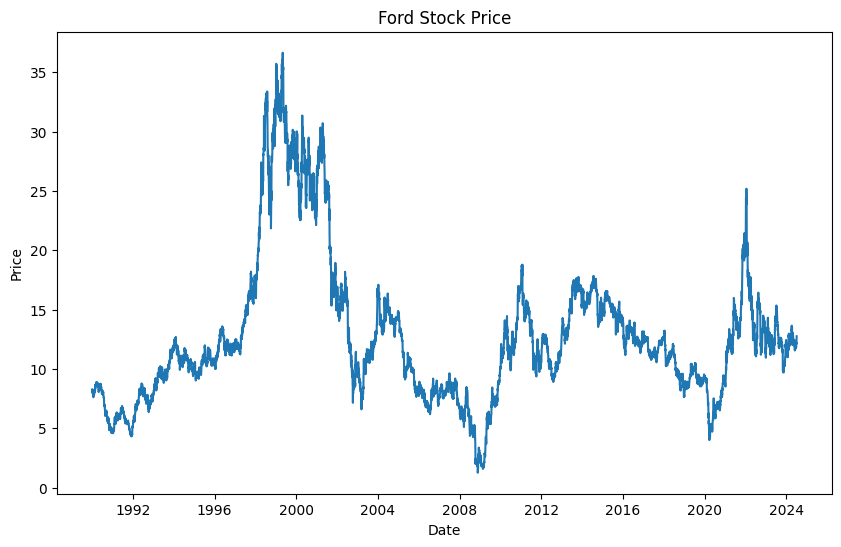

In [163]:
plt.figure(figsize=(10, 6))
plt.plot(ford.index, ford['Close'])
plt.title('Ford Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [164]:
time_step = [['2000', '2010'], ['2010', '2020']]

In [165]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = StandardScaler()
scaler.fit(ford[['Open', 'High', 'Low', 'Close', 'Volume']])
ford[['Open', 'High', 'Low', 'Close', 'Volume']] = scaler.transform(ford[['Open', 'High', 'Low', 'Close', 'Volume']])

In [166]:
# 1df = pd.DataFrame(scaled, columns=)\
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(ford.drop('Close', axis=1), ford['Close'], test_size=0.2, random_state=42, shuffle=True)

In [167]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [168]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [169]:
WINDOW_SIZE = 20
BATCH_SIZE = 32

In [170]:
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [171]:
for data in train_data.take(1):
  print('X', data[0].shape)
  print('y', data[1].shape)

X (32, 20, 1)
y (32, 1)


### 모델

In [172]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [173]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [174]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

In [175]:
history = model.fit(train_data,
                    validation_data=(test_data),
                    epochs=50,
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
    211/Unknown - 3s 5ms/step - loss: 0.3674 - mse: 1.0288
Epoch 1: val_loss improved from inf to 0.35812, saving model to tmp/ckeckpointer.ckpt
217/217 [==============================] - 4s 8ms/step - loss: 0.3673 - mse: 1.0281 - val_loss: 0.3581 - val_mse: 0.9967
Epoch 2/50
209/217 [===========================>..] - ETA: 0s - loss: 0.3674 - mse: 1.0342
Epoch 2: val_loss did not improve from 0.35812
217/217 [==============================] - 1s 6ms/step - loss: 0.3664 - mse: 1.0309 - val_loss: 0.3584 - val_mse: 0.9942
Epoch 3/50
214/217 [============================>.] - ETA: 0s - loss: 0.3672 - mse: 1.0326
Epoch 3: val_loss did not improve from 0.35812
217/217 [==============================] - 1s 6ms/step - loss: 0.3663 - mse: 1.0300 - val_loss: 0.3584 - val_mse: 0.9956
Epoch 4/50
211/217 [============================>.] - ETA: 0s - loss: 0.3642 - mse: 1.0229
Epoch 4: val_loss did not improve from 0.35812
217/217 [==============================] - 1s 5ms/step - loss: 0.36

In [176]:
model.load_weights(filename)

In [177]:
pred = model.predict(test_data)

54/54 [==============================] - 1s 3ms/step


In [178]:
pred.shape

(1718, 1)

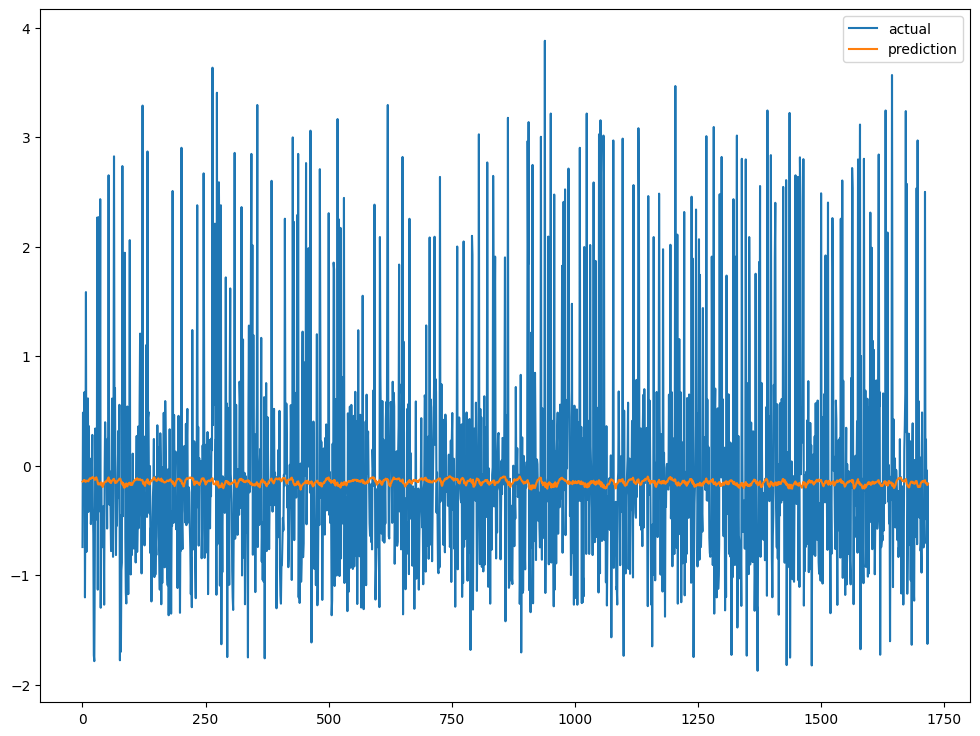

In [179]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()